# Project 3 - Web APIs & Classification on subreddit

The objective of this project is to choose two subreddits from Reddit and use natural language processing and classification models to classify posts into the correct subreddit .

In this project will classify Reddit posts from scuba diving subreddit and hiking subreddit as my two topics of interest because both of them are under same main community 'travel', but are also differentiated enough that it should be possible to train a machine learning model.

### The problem statement
In recent years, travellers become ever-more worldly, the desire for adventure increases. Scuba diving and Hiking are adventure sport that allow us to explore the world above and under water. Therefore for a travel agency who needs to seek for adventure traveler among the people on the internet. Therefore by knowing a dominant words that people use to discuss and search about scuba diving and hiking can helps the travel agency spot their customers.

## Imports

In [298]:
import numpy as np
import pandas as pd
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, plot_confusion_matrix
from nltk.stem.porter import PorterStemmer
from bs4 import BeautifulSoup
import regex as re
from sklearn.pipeline import Pipeline

%matplotlib inline
lemmatizer = WordNetLemmatizer()
stops=stopwords.words('english')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### Imports data

As we are going to classifying **scuba diving** and **hiking** subreddits through natural language processing and classification models.
The columns we going to use are:
<ul>
    <li>subreddit</li>
    <li>title</li>
    <li>selftext</li>
</ul>

In [299]:
scuba = pd.read_csv('../data/reddit_scuba.csv')
hike = pd.read_csv('../data/reddit_hike.csv')

In [300]:
# Display first 5 rows of scuba
scuba.head()

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,subreddit_name_prefixed,hidden,pwls,link_flair_css_class,downs,thumbnail_height,top_awarded_type,hide_score,name,quarantine,link_flair_text_color,upvote_ratio,author_flair_background_color,subreddit_type,ups,total_awards_received,media_embed,thumbnail_width,author_flair_template_id,is_original_content,user_reports,secure_media,is_reddit_media_domain,is_meta,category,secure_media_embed,link_flair_text,can_mod_post,score,approved_by,author_premium,thumbnail,edited,author_flair_css_class,author_flair_richtext,gildings,content_categories,is_self,mod_note,created,link_flair_type,wls,removed_by_category,banned_by,author_flair_type,domain,allow_live_comments,selftext_html,likes,suggested_sort,banned_at_utc,view_count,archived,no_follow,is_crosspostable,pinned,over_18,all_awardings,awarders,media_only,can_gild,spoiler,locked,author_flair_text,treatment_tags,visited,removed_by,num_reports,distinguished,subreddit_id,mod_reason_by,removal_reason,link_flair_background_color,id,is_robot_indexable,report_reasons,author,discussion_type,num_comments,send_replies,whitelist_status,contest_mode,mod_reports,author_patreon_flair,author_flair_text_color,permalink,parent_whitelist_status,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,post_hint,url_overridden_by_dest,preview,is_gallery,media_metadata,gallery_data,crosspost_parent_list,crosspost_parent,poll_data,author_cakeday
0,NaN,scuba,Fellow r/scuba divers! While we're all at hom...,t2_62djm3lb,False,NaN,0,False,Join Diving@home (Team# 239856) to help fight ...,[],r/scuba,False,6,NaN,0,NaN,NaN,False,t3_fywlaq,False,dark,0.96,NaN,public,29,1,{},NaN,NaN,False,[],NaN,False,False,NaN,{},NaN,False,29,NaN,False,self,1586615371.0,NaN,[],{},NaN,True,NaN,1.586609e+09,text,6,NaN,NaN,text,self.scuba,True,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,NaN,NaN,NaN,True,False,False,False,False,"[{'giver_coin_reward': None, 'subreddit_id': N...",[],False,False,False,False,NaN,[],False,NaN,NaN,NaN,t5_2qhii,NaN,NaN,NaN,fywlaq,True,NaN,AmbitiousDiver0,NaN,5,True,all_ads,False,[],False,NaN,/r/scuba/comments/fywlaq/join_divinghome_team_...,all_ads,True,https://www.reddit.com/r/scuba/comments/fywlaq...,95206,1.586580e+09,0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,scuba,"Hello everybody,\n\n&amp;#x200B;\n\nRegardless...",t2_1596fb,False,NaN,0,False,Holiday Gift Thread,[],r/scuba,False,6,NaN,0,NaN,NaN,False,t3_kjstq7,False,dark,1.00,NaN,public,10,0,{},NaN,NaN,False,[],NaN,False,False,NaN,{},NaN,False,10,NaN,False,self,False,NaN,[],{},NaN,True,NaN,1.608898e+09,text,6,NaN,NaN,text,self.scuba,False,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,NaN,NaN,NaN,False,False,False,False,False,[],[],False,False,False,False,NaN,[],False,NaN,NaN,moderator,t5_2qhii,NaN,NaN,NaN,kjstq7,True,NaN,DiveBiologist,NaN,10,True,all_ads,False,[],False,NaN,/r/scuba/comments/kjstq7/holiday_gift_thread/,all_ads,True,https://www.reddit.com/r/scuba/comments/kjstq7...,95206,1.608869e+09,0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,scuba,NaN,t2_al8vsc8s,False,NaN,0,False,Octopus changes into coral,[],r/scuba,False,6,NaN,0,78.0,NaN,False,t3_m2p8hm,False,dark,0.99,NaN,public,655,1,{},140.0,NaN,False,[],"{'reddit_video': {'bitrate_kbps': 2400, 'fallb...",True,False,NaN,{},NaN,False,655,NaN,False,https://a.thumbs.redditmedia.com/lEakVVotHr4zA...,False,NaN,[],{},NaN,False,NaN,1.615495e+09,text,6,NaN,NaN,text,v.redd.it,False,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,"[{'giver_coin_reward': 0, 'subreddit_id': None...",[],False,False,False,False,NaN,[],False,NaN,NaN,NaN,t5_2qhii,NaN,NaN,NaN,m2p8hm,True,NaN,elloisitmeurlukin4,NaN,23,True,all_ads,False,[],False,NaN,/r/scuba/comments/m2p8hm/octopus_changes_into_...,all_ads,False,https://v.redd.it/gx1nspsc8em61,95206,1.615467e+09,1,"{'reddit_video': {'bitrate_kbps': 2400, 'fallb...",True,hosted:video,https://v.re

In [301]:
# scuba shape
scuba.shape

(991, 114)

In [302]:
# check scuba duplicate rows - 27 duplicated rows
scuba[scuba.duplicated(['name'])].shape[0]

27

In [303]:
# drop scuba dubplicated row
scuba.drop_duplicates(subset='name', keep='first', inplace=True)

In [304]:
# check rows after drop
scuba.shape

(964, 114)

In [305]:
# check duplicate rows - no dup
scuba[scuba.duplicated(['name'])].shape[0]

0

In [306]:
# Display first 5 rows of hike
hike.head()

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,subreddit_name_prefixed,hidden,pwls,link_flair_css_class,downs,thumbnail_height,top_awarded_type,hide_score,name,quarantine,link_flair_text_color,upvote_ratio,author_flair_background_color,subreddit_type,ups,total_awards_received,media_embed,thumbnail_width,author_flair_template_id,is_original_content,user_reports,secure_media,is_reddit_media_domain,is_meta,category,secure_media_embed,link_flair_text,can_mod_post,score,approved_by,author_premium,thumbnail,edited,author_flair_css_class,author_flair_richtext,gildings,post_hint,content_categories,is_self,mod_note,created,link_flair_type,wls,removed_by_category,banned_by,author_flair_type,domain,allow_live_comments,selftext_html,likes,suggested_sort,banned_at_utc,url_overridden_by_dest,view_count,archived,no_follow,is_crosspostable,pinned,over_18,preview,all_awardings,awarders,media_only,can_gild,spoiler,locked,author_flair_text,treatment_tags,visited,removed_by,num_reports,distinguished,subreddit_id,mod_reason_by,removal_reason,link_flair_background_color,id,is_robot_indexable,report_reasons,author,discussion_type,num_comments,send_replies,whitelist_status,contest_mode,mod_reports,author_patreon_flair,author_flair_text_color,permalink,parent_whitelist_status,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,link_flair_template_id,is_gallery,media_metadata,gallery_data,author_cakeday,crosspost_parent_list,crosspost_parent
0,NaN,hiking,NaN,t2_71kaa24x,False,NaN,0,False,"Cathedral Rock- Sedona, Arizona, USA",[],r/hiking,False,6,green,0,140.0,NaN,False,t3_m36kit,False,dark,0.99,NaN,public,677,3,{},140.0,NaN,False,[],NaN,True,False,NaN,{},Pictures,False,677,NaN,False,https://b.thumbs.redditmedia.com/PootuTWAl-MN1...,False,NaN,[],{'gid_1': 1},image,NaN,False,NaN,1.615542e+09,text,6,NaN,NaN,text,i.redd.it,False,NaN,NaN,NaN,NaN,https://i.redd.it/aaelwv306im61.jpg,NaN,False,False,False,False,False,{'images': [{'source': {'url': 'https://previe...,"[{'giver_coin_reward': None, 'subreddit_id': N...",[],False,False,False,False,NaN,[],False,NaN,NaN,NaN,t5_2r9om,NaN,NaN,NaN,m36kit,True,NaN,bigfootschmigfoot,NaN,13,True,all_ads,False,[],False,NaN,/r/hiking/comments/m36kit/cathedral_rock_sedon...,all_ads,False,https://i.redd.it/aaelwv306im61.jpg,1347658,1.615514e+09,0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,hiking,NaN,t2_atut9y1f,False,NaN,0,False,"Ture Dalar nature reserve, Uddevalla, Sweden",[],r/hiking,False,6,green,0,140.0,NaN,False,t3_m348yo,False,dark,1.00,NaN,public,498,1,{},140.0,NaN,False,[],NaN,True,False,NaN,{},Pictures,False,498,NaN,False,https://b.thumbs.redditmedia.com/yuzIp21gDCtk5...,False,NaN,[],{},image,NaN,False,NaN,1.615536e+09,text,6,NaN,NaN,text,i.redd.it,False,NaN,NaN,NaN,NaN,https://i.redd.it/54g78ztdlhm61.jpg,NaN,False,False,False,False,False,{'images': [{'source': {'url': 'https://previe...,"[{'giver_coin_reward': None, 'subreddit_id': N...",[],False,False,False,False,NaN,[],False,NaN,NaN,NaN,t5_2r9om,NaN,NaN,NaN,m348yo,True,NaN,hasmatter,NaN,6,True,all_ads,False,[],False,NaN,/r/hiking/comments/m348yo/ture_dalar_nature_re...,all_ads,False,https://i.redd.it/54g78ztdlhm61.jpg,1347658,1.615507e+09,0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,hiking,NaN,t2_50eydsiu,False,NaN,0,False,Thor's cave - Peak District - UK (3456X5184) [OC],[],r/hiking,False,6,green,0,140.0,NaN,False,t3_m35fr2,False,dark,0.99,NaN,public,392,1,{},140.0,NaN,False,[],NaN,True,False,NaN,{},Pictures,False,392,NaN,False,https://b.thumbs.redditmedia.com/BEwuqmIgh8cTK...,False,NaN,[],{},image,NaN,False,NaN,1.615539e+09,text,6,NaN,NaN,text,i.redd.it,False,NaN,NaN,NaN,NaN,https://i.redd.it/p7uya7xtvhm61.jpg,NaN,False,False,False,False,False,{'images': [{'source': {'url': 'https://previe...,"[{'giver_coin_reward': None, 'subreddit_id': N...",[],False,False,False,False,NaN,[],False,NaN,NaN,NaN,t5_2r9om,NaN,NaN,NaN,m35fr2,True,NaN,scott_1882,NaN,2,True,all_ads,False,

In [307]:
# hike shape
hike.shape

(990, 114)

In [308]:
# check scuba duplicate rows - 25 duplicated rows
hike[hike.duplicated(['name'])].shape[0]

25

In [309]:
# drop hike dubplicated row
hike.drop_duplicates(subset='name', keep='first', inplace=True)

In [310]:
# check rows after drop
hike.shape

(965, 114)

In [311]:
# check duplicate rows - no dup
hike[hike.duplicated(['name'])].shape[0]

0

## Features engineering

Feature Engineering
Upon observation, some of the posts have empty selftexts (possibly because the post linked directly to an image which we could not pull).
These posts still have valuable information in their titles and we should not drop them.
As such, we will engineer a new feature that combines the title and selftext strings, and fill NaN values to enable them to be joined.

Therefore by combine **title** and **selftext** and remove all duplicated rows, the number of posts in scuba diving subredit is at 964 post and for the number of posts in hiking subredit is at 965 post.
Which results in the proportion of scuba diving and hiking remains at 50-50.

In [312]:
scuba[['subreddit','title','selftext']].head()

,subreddit,title,selftext
0,scuba,Join Diving@home (Team# 239856) to help fight ...,Fellow r/scuba divers! While we're all at hom...
1,scuba,Holiday Gift Thread,"Hello everybody,\n\n&amp;#x200B;\n\nRegardless..."
2,scuba,Octopus changes into coral,NaN
3,scuba,Pelagic Magic pt 2: A larval Slipper Lobster r...,NaN
4,scuba,Beautiful Manta at Julian Rocks Byron Bay,NaN


In [313]:
hike[['subreddit','title','selftext']].head()

,subreddit,title,selftext
0,hiking,"Cathedral Rock- Sedona, Arizona, USA",NaN
1,hiking,"Ture Dalar nature reserve, Uddevalla, Sweden",NaN
2,hiking,Thor's cave - Peak District - UK (3456X5184) [OC],NaN
3,hiking,Eden grove on Vancouver island,NaN
4,hiking,A secluded waterfall ravine in Iceland. One of...,NaN


In [314]:
# Keep only useful columns
scuba = scuba[['title','selftext','subreddit']]
hike = hike[['title','selftext','subreddit']]

In [315]:
# combine title and selftext to text column
scuba['text']=scuba.fillna('')['title']+scuba.fillna('')['selftext']
hike['text']=hike.fillna('')['title']+hike.fillna('')['selftext']

In [316]:
scuba.head()

,title,selftext,subreddit,text
0,Join Diving@home (Team# 239856) to help fight ...,Fellow r/scuba divers! While we're all at hom...,scuba,Join Diving@home (Team# 239856) to help fight ...
1,Holiday Gift Thread,"Hello everybody,\n\n&amp;#x200B;\n\nRegardless...",scuba,"Holiday Gift ThreadHello everybody,\n\n&amp;#x..."
2,Octopus changes into coral,NaN,scuba,Octopus changes into coral
3,Pelagic Magic pt 2: A larval Slipper Lobster r...,NaN,scuba,Pelagic Magic pt 2: A larval Slipper Lobster r...
4,Beautiful Manta at Julian Rocks Byron Bay,NaN,scuba,Beautiful Manta at Julian Rocks Byron Bay


In [317]:
hike.head()

,title,selftext,subreddit,text
0,"Cathedral Rock- Sedona, Arizona, USA",NaN,hiking,"Cathedral Rock- Sedona, Arizona, USA"
1,"Ture Dalar nature reserve, Uddevalla, Sweden",NaN,hiking,"Ture Dalar nature reserve, Uddevalla, Sweden"
2,Thor's cave - Peak District - UK (3456X5184) [OC],NaN,hiking,Thor's cave - Peak District - UK (3456X5184) [OC]
3,Eden grove on Vancouver island,NaN,hiking,Eden grove on Vancouver island
4,A secluded waterfall ravine in Iceland. One of...,NaN,hiking,A secluded waterfall ravine in Iceland. One of...


In [318]:
# change subreddit: scuba-1, hiking-0
scuba['subreddit'] = scuba['subreddit'].replace('scuba',1)
hike['subreddit'] = hike['subreddit'].replace('hiking',0)

In [319]:
display(scuba.head())
display(hike.head())

,title,selftext,subreddit,text
0,Join Diving@home (Team# 239856) to help fight ...,Fellow r/scuba divers! While we're all at hom...,1,Join Diving@home (Team# 239856) to help fight ...
1,Holiday Gift Thread,"Hello everybody,\n\n&amp;#x200B;\n\nRegardless...",1,"Holiday Gift ThreadHello everybody,\n\n&amp;#x..."
2,Octopus changes into coral,NaN,1,Octopus changes into coral
3,Pelagic Magic pt 2: A larval Slipper Lobster r...,NaN,1,Pelagic Magic pt 2: A larval Slipper Lobster r...
4,Beautiful Manta at Julian Rocks Byron Bay,NaN,1,Beautiful Manta at Julian Rocks Byron Bay


,title,selftext,subreddit,text
0,"Cathedral Rock- Sedona, Arizona, USA",NaN,0,"Cathedral Rock- Sedona, Arizona, USA"
1,"Ture Dalar nature reserve, Uddevalla, Sweden",NaN,0,"Ture Dalar nature reserve, Uddevalla, Sweden"
2,Thor's cave - Peak District - UK (3456X5184) [OC],NaN,0,Thor's cave - Peak District - UK (3456X5184) [OC]
3,Eden grove on Vancouver island,NaN,0,Eden grove on Vancouver island
4,A secluded waterfall ravine in Iceland. One of...,NaN,0,A secluded waterfall ravine in Iceland. One of...


In [320]:
# drop unnecessary columns titke and selftext
scuba.drop(columns=['title', 'selftext'],inplace=True)
hike.drop(columns=['title', 'selftext'],inplace=True)

In [321]:
display(scuba.head())
display(hike.head())

,subreddit,text
0,1,Join Diving@home (Team# 239856) to help fight ...
1,1,"Holiday Gift ThreadHello everybody,\n\n&amp;#x..."
2,1,Octopus changes into coral
3,1,Pelagic Magic pt 2: A larval Slipper Lobster r...
4,1,Beautiful Manta at Julian Rocks Byron Bay


,subreddit,text
0,0,"Cathedral Rock- Sedona, Arizona, USA"
1,0,"Ture Dalar nature reserve, Uddevalla, Sweden"
2,0,Thor's cave - Peak District - UK (3456X5184) [OC]
3,0,Eden grove on Vancouver island
4,0,A secluded waterfall ravine in Iceland. One of...


In [322]:
# append 2 subreddit into 1 dataframe
reddit_text = scuba.append(hike,ignore_index=True)

In [323]:
display(reddit_text.head())
display(reddit_text.tail())

,subreddit,text
0,1,Join Diving@home (Team# 239856) to help fight ...
1,1,"Holiday Gift ThreadHello everybody,\n\n&amp;#x..."
2,1,Octopus changes into coral
3,1,Pelagic Magic pt 2: A larval Slipper Lobster r...
4,1,Beautiful Manta at Julian Rocks Byron Bay


,subreddit,text
1924,0,I took my wife on her first official backpacki...
1925,0,Old Agrico Trail. Alafia River State Park. Lit...
1926,0,My favorite trail
1927,0,Followed a trail laid down by a snowshoer on a...
1928,0,Gosausee - incredible Upper Austrian Alps 🇦🇹 🍄...


In [324]:
# check reddit text shape
reddit_text.shape

(1929, 2)

In [325]:
# change all text to lowcase
reddit_text=reddit_text.apply(lambda x: x.str.lower() if(x.dtype == 'object') else x)

In [326]:
# export text to csv
reddit_text.to_csv('../data/reddit_text.csv',index=False)

In [327]:
# save copy and go on with reddit
reddit = reddit_text.copy()

In [328]:
display(reddit.head())
display(reddit.tail())

,subreddit,text
0,1,join diving@home (team# 239856) to help fight ...
1,1,"holiday gift threadhello everybody,\n\n&amp;#x..."
2,1,octopus changes into coral
3,1,pelagic magic pt 2: a larval slipper lobster r...
4,1,beautiful manta at julian rocks byron bay


,subreddit,text
1924,0,i took my wife on her first official backpacki...
1925,0,old agrico trail. alafia river state park. lit...
1926,0,my favorite trail
1927,0,followed a trail laid down by a snowshoer on a...
1928,0,gosausee - incredible upper austrian alps 🇦🇹 🍄...


**Create a funtion for clean text by:**
<ol>
    <li>Remove HTML</li>
    <li>Remove non-letters</li>
    <li>Remove stopwords</li>
    <li>Stemming</li>
</ol>

In [329]:
def raw_to_words(raw_review):
    # Function to convert a raw review to a string of words

    # 1. Remove HTML.
    review_text = BeautifulSoup(raw_review).get_text()
    
    # 2. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    
    # 3. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # define stopword
    stops.extend(['scuba','dive','hike'])
    
    # 4. Remove stopwords.
    meaningful_words = [w for w in words if w not in stops]
    
    # 6. Stemming
    # Instantiate object of class PorterStemmer.
    p_stemmer = PorterStemmer()
    meaningful_words = [p_stemmer.stem(w) for w in meaningful_words]

    
    # 7. Remove stopwords agian.
    meaningful_words = [w for w in meaningful_words if w not in stops]
    
    
    # 8. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))

Clean reddit text by using the loop

In [330]:
# Initialize an empty list to hold the clean reviews.
clean_text = []

print("Cleaning and parsing text from reddit...")

# Instantiate counter.
j = 0

# For every review in our training set...
for raw in reddit['text']:
    
    # Convert review to words, then append to clean_train_reviews.
    clean_text.append(raw_to_words(raw))
    
    # If the index is divisible by 100, print a message.
    if (j + 1) % 100 == 0:
        print(f'Clean {j + 1} of {reddit.shape[0]}.')
    
    j += 1

Cleaning and parsing text from reddit...
Clean 100 of 1929.
Clean 200 of 1929.
Clean 300 of 1929.
Clean 400 of 1929.
Clean 500 of 1929.
Clean 600 of 1929.
Clean 700 of 1929.
Clean 800 of 1929.
Clean 900 of 1929.
Clean 1000 of 1929.
Clean 1100 of 1929.
Clean 1200 of 1929.
Clean 1300 of 1929.
Clean 1400 of 1929.
Clean 1500 of 1929.
Clean 1600 of 1929.
Clean 1700 of 1929.
Clean 1800 of 1929.
Clean 1900 of 1929.


In [331]:
# display first 5 cleaned text
clean_text[:5]

['join home team help fight covid fellow r diver home post away also help fight covid bit extra comput power lie around help fold protein cure research pleas consid support folk fold home download http foldingathom org start fold http foldingathom org start fold automat select sar cov thing want help deciph like support r fold home team home team stat http fold extremeoverclock com team summari php http fold extremeoverclock com team summari php http stat foldingathom org team http stat foldingathom org team',
 'holiday gift threadhello everybodi x b regardless holiday celebr even none mani peopl give receiv gift around time year near year use thread rave newest gift plan new year x b new reg set new light new mask strap new rebreath big spender awesom show us tell us use come year x b happi',
 'octopu chang coral',
 'pelag magic pt larval slipper lobster ride jelli ocean ft ft water everi night trillion organ like rise depth feed plankton surfac sink back morn',
 'beauti manta julian 

In [332]:
# create columns clean text in reddit df
reddit['clean_text'] = clean_text
reddit.head()

,subreddit,text,clean_text
0,1,join diving@home (team# 239856) to help fight ...,join home team help fight covid fellow r diver...
1,1,"holiday gift threadhello everybody,\n\n&amp;#x...",holiday gift threadhello everybodi x b regardl...
2,1,octopus changes into coral,octopu chang coral
3,1,pelagic magic pt 2: a larval slipper lobster r...,pelag magic pt larval slipper lobster ride jel...
4,1,beautiful manta at julian rocks byron bay,beauti manta julian rock byron bay


In [333]:
# export cleaned reddit to csv
reddit.to_csv('../data/reddit_clean.csv', index=False)

## EDA

#### by wordcloud

In [362]:
from wordcloud import WordCloud

In [572]:
# remove label words (scuba,hike) and stopwords which common appears in both subreddit 
stops.extend(['scuba','dive','hike','diver','hiker','go','look','use','one','want','good', 'thank', 'think', 'know','time'
             ,'need','new','anyon','first', 'day','year','got'])

reddit['clean_text'] = reddit['clean_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stops)]))

In [364]:
# change subreddit into number 0:hiking, 1:scuba diving
text_scuba = reddit.loc[(reddit['subreddit'] == 1)]['clean_text']
text_hike = reddit.loc[(reddit['subreddit'] == 0)]['clean_text']

In [495]:
# function for create grey scale color for wordcloud 
def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % np.random.randint(60, 100)

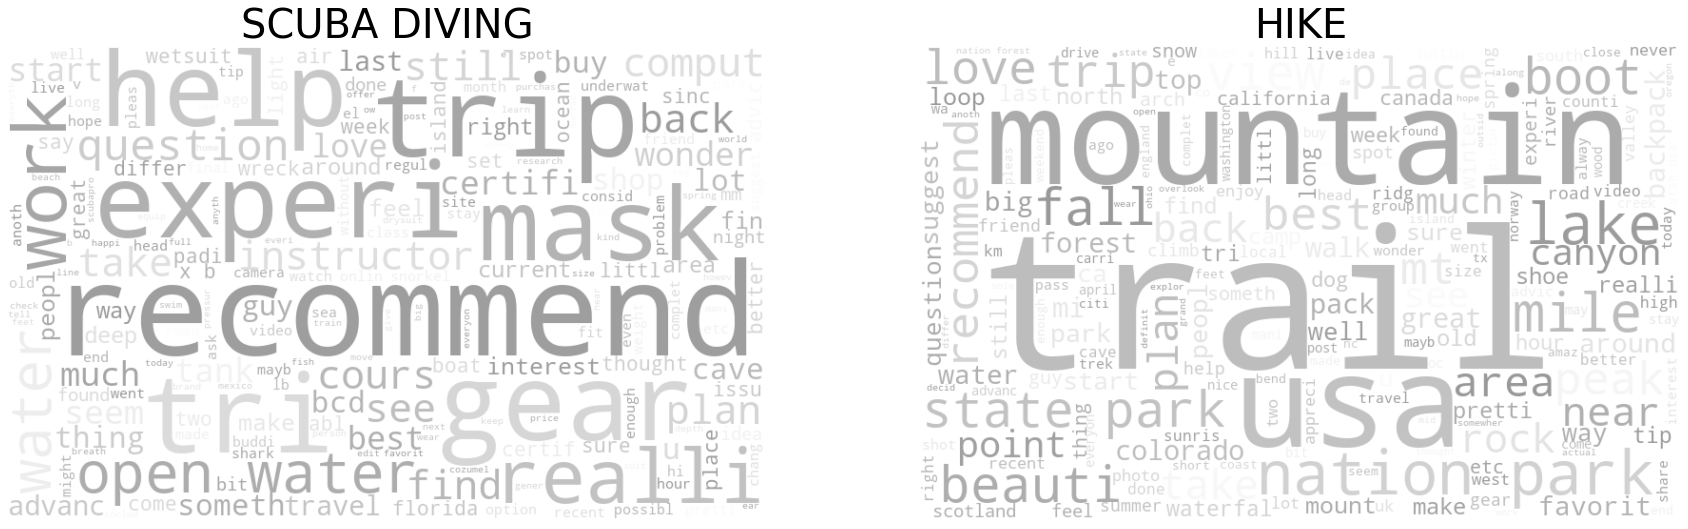

In [496]:
wc_scuba = WordCloud(background_color='White',width=800,height=500).generate(' '.join(text_scuba))
wc_hike = WordCloud(background_color='White',width=800,height=500).generate(' '.join(text_hike))
fig, axs = plt.subplots(1,2)

fig.set_figheight(15)
fig.set_figwidth(30)

axs[0].imshow(wc_scuba.recolor(color_func=grey_color_func, random_state=3),
           interpolation="bilinear")
axs[0].axis("off")
axs[0].set_title('SCUBA DIVING',fontsize=40)

axs[1].imshow(wc_hike.recolor(color_func=grey_color_func, random_state=3),
           interpolation="bilinear")
axs[1].axis("off")
axs[1].set_title('HIKE',fontsize=40)
plt.show()

The wordcloud shows, 'trip','recommend'and 'help' are the most frequency words in the scuba diving subreddit and for the hiking subreddit 'trail', 'mountain' and 'usa' are the most frequency words.

#### TOP 25 most frequency words

Create function for lemmatize text in to word for count frequency words

In [366]:
import nltk
from nltk.probability import FreqDist

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

In [367]:
reddit['lemmatized_text'] = reddit['clean_text'].apply(lemmatize_text)

In [368]:
reddit.head()

,subreddit,text,clean_text,lemmatized_text,word_count
0,1,join diving@home (team# 239856) to help fight ...,join home team help fight covid fellow r home ...,"[join, home, team, help, fight, covid, fellow,...",83
1,1,"holiday gift threadhello everybody,\n\n&amp;#x...",holiday gift threadhello everybodi x b regardl...,"[holiday, gift, threadhello, everybodi, x, b, ...",46
2,1,octopus changes into coral,octopu chang coral,"[octopu, chang, coral]",3
3,1,pelagic magic pt 2: a larval slipper lobster r...,pelag magic pt larval slipper lobster ride jel...,"[pelag, magic, pt, larval, slipper, lobster, r...",25
4,1,beautiful manta at julian rocks byron bay,beauti manta julian rock byron bay,"[beauti, manta, julian, rock, byron, bay]",6


In [369]:
words = reddit['lemmatized_text']
allwords = []
for wordlist in words:
    allwords += wordlist

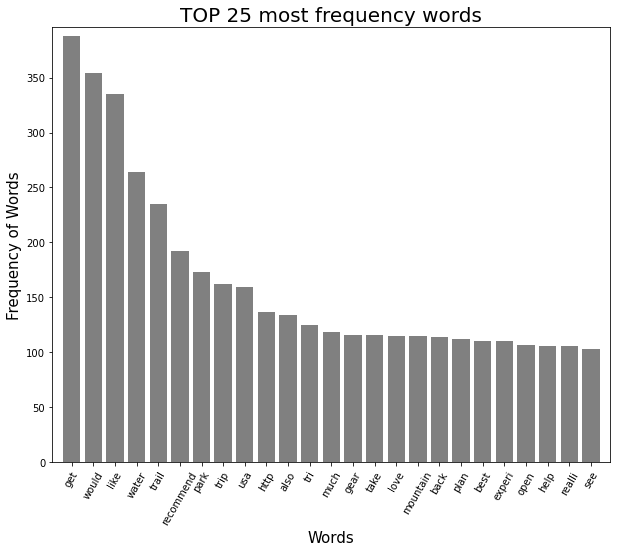

In [500]:
mostcommon_small = FreqDist(allwords).most_common(25)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(10,8))
plt.margins(0.02)
plt.bar(x, y,color='grey')
plt.xlabel('Words', fontsize=15)
plt.ylabel('Frequency of Words', fontsize=15)
plt.yticks(fontsize=10)
plt.xticks(rotation=60, fontsize=10)
plt.title('TOP 25 most frequency words', fontsize=20)
plt.show()

The first top 3 most frequency words is 'get', 'would', and 'like' which has no spacific meaning.

#### Average word count by subreddit

In [371]:
reddit['word_count'] = reddit['lemmatized_text'].map(lambda x: len(x))

In [372]:
word_count_mean = reddit.groupby('subreddit')[['word_count']].mean()
word_count_mean

,word_count
subreddit,
0,13.082902
1,27.451245


[Text(0, 0, 'Hiking'), Text(1, 0, 'Scuba diving')]

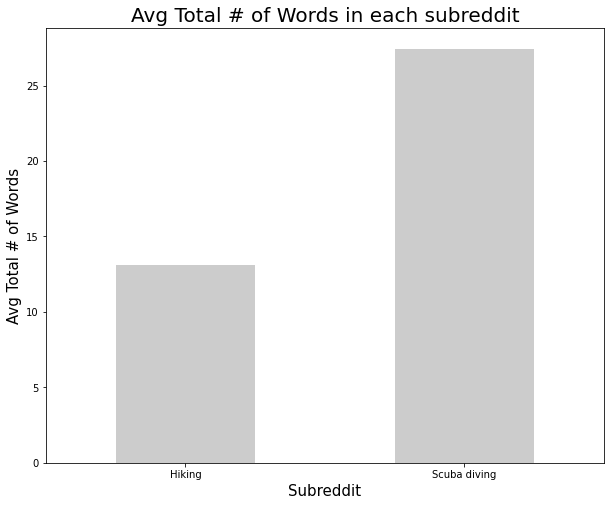

In [492]:
ax = word_count_mean['word_count'].plot(kind='bar', figsize=(10,8),colormap='Pastel2_r');
ax.set_alpha(0.8)
ax.set_title('Avg Total # of Words in each subreddit', fontsize = 20)
ax.set_ylabel('Avg Total # of Words', fontsize = 15);
ax.set_xlabel('Subreddit', fontsize = 15)
labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = 'Hiking'
labels[1] = 'Scuba diving'
ax.set_xticklabels(labels, rotation=0, fontsize=10)

On average, it appears people are more verbose in the scuba diving subreddit than the hiking subreddit. Posts are 27 words on average in the scuba diving subreddit and 13 words on average in the hiking subreddit.

## Modelling

In [374]:
display(reddit.head())
display(reddit.tail())

,subreddit,text,clean_text,lemmatized_text,word_count
0,1,join diving@home (team# 239856) to help fight ...,join home team help fight covid fellow r home ...,"[join, home, team, help, fight, covid, fellow,...",83
1,1,"holiday gift threadhello everybody,\n\n&amp;#x...",holiday gift threadhello everybodi x b regardl...,"[holiday, gift, threadhello, everybodi, x, b, ...",42
2,1,octopus changes into coral,octopu chang coral,"[octopu, chang, coral]",3
3,1,pelagic magic pt 2: a larval slipper lobster r...,pelag magic pt larval slipper lobster ride jel...,"[pelag, magic, pt, larval, slipper, lobster, r...",25
4,1,beautiful manta at julian rocks byron bay,beauti manta julian rock byron bay,"[beauti, manta, julian, rock, byron, bay]",6


,subreddit,text,clean_text,lemmatized_text,word_count
1924,0,i took my wife on her first official backpacki...,took wife offici backpack trip made video,"[took, wife, offici, backpack, trip, made, video]",7
1925,0,old agrico trail. alafia river state park. lit...,old agrico trail alafia river state park lithi...,"[old, agrico, trail, alafia, river, state, par...",10
1926,0,my favorite trail,favorit trail,"[favorit, trail]",2
1927,0,followed a trail laid down by a snowshoer on a...,follow trail laid snowshoer river ontario canada,"[follow, trail, laid, snowshoer, river, ontari...",7
1928,0,gosausee - incredible upper austrian alps 🇦🇹 🍄...,gosause incred upper austrian alp,"[gosause, incred, upper, austrian, alp]",5


In [375]:
# check null values
reddit.isnull().sum()

subreddit          0
text               0
clean_text         0
lemmatized_text    0
word_count         0
dtype: int64

### Train-Test split

In [376]:
# assign X and y
X = reddit['clean_text']
y = reddit['subreddit']

In [377]:
# check base model
y.value_counts(normalize=True)

0    0.500259
1    0.499741
Name: subreddit, dtype: float64

In [378]:
# train test split
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y) 

In [379]:
# check portion
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

1    0.5
0    0.5
Name: subreddit, dtype: float64
0    0.501035
1    0.498965
Name: subreddit, dtype: float64


### Model Selection

create pipeline using CountVectorizer, TfidfVectorizer combine with LogisticRegression, Naive Bayes and KNeighbors

In [380]:
# Creates 2 Logistic Regression pipelines using count and tfidf vectorizers
pipe_cvec_lr = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])
pipe_tvec_lr = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

# Creates four Naive Bayes pipelines with Multinomial and binomial NB using count and tfidf vectorizers
pipe_cvec_mn = Pipeline([
    ('cvec', CountVectorizer()),
    ('mn', MultinomialNB())
])
pipe_tvec_mn = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('mn', MultinomialNB())
])
pipe_cvec_bn = Pipeline([
    ('cvec', CountVectorizer()),
    ('bn', BernoulliNB())
])
pipe_tvec_bn = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('bn', BernoulliNB())
])

# Creates two Knn pipelines using count and tfidf vectorizers
pipe_cvec_knn = Pipeline([
    ('cvec', CountVectorizer()),
    ('knn', KNeighborsClassifier())
])
pipe_tvec_knn = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('knn', KNeighborsClassifier())
])

Create parameter for use in grid search

In [463]:
# search params
params_1 = {
    'cvec__max_features':[2000,3000,4000,None],
    'cvec__min_df': [2,3],
    'cvec__max_df': [0.8,0.9,1.0],
    'cvec__ngram_range':[(1,1),(1,2),(1,3)]
}
params_2 = {
    'tvec__max_features':[2000,3000,4000,None],
    'tvec__min_df': [2,3],
    'tvec__max_df': [0.8,0.9,1.0],
    'tvec__ngram_range':[(1,1),(1,2),(1,3)]
}
params_3 = {
    'cvec__max_features':[2000,3000,4000,None],
    'cvec__min_df': [2,3],
    'cvec__max_df': [0.8,0.9,1.0],
    'cvec__ngram_range':[(1,1),(1,2),(1,3)],
    'knn__n_neighbors': [5,10,30,50]
}
params_4 = {
    'tvec__max_features':[2000,3000,4000,None],
    'tvec__min_df': [2,3],
    'tvec__max_df': [0.8,0.9,1.0],
    'tvec__ngram_range':[(1,1),(1,2),(1,3)],
    'knn__n_neighbors': [5,10,30,50]
}
params_gs_cvec_lr = {
    'cvec__max_features':[2000,3000,4000,None],
    'cvec__min_df': [2,3],
    'cvec__max_df': [0.8,0.9,1.0],
    'cvec__ngram_range':[(1,1),(1,2),(1,3)],
    'lr__C': [0.01,0.1,1.0],
}
params_gs_tvec_lr = {
    'tvec__max_features':[2000,3000,4000,None],
    'tvec__min_df': [2,3],
    'tvec__max_df': [0.8,0.9,1.0],
    'tvec__ngram_range':[(1,1),(1,2),(1,3)],
    'lr__C': [0.01,0.1,1.0],
}

In [464]:
# function for creates a grid search given a pipeline, set of params to search over and data to train on,
# prints out best params found, and train with test score
def gs(pipe,params,X_train,y_train,X_test,y_test):
    
    gs = GridSearchCV(pipe,param_grid=params)
    
    gs.fit(X_train,y_train);
    
    print('Best parameters:', gs.best_params_)
    print('Train score:', gs.score(X_train,y_train))
    print('Cross Validation Score:', gs.best_score_)
    print('Test Score:', gs.score(X_test,y_test))
    
    return gs

### Logistic Regression Models

#### CountVectorizer

In [465]:
# Logistic Regression with count vectorizer
gs_cvec_lr = gs(pipe_cvec_lr,params_gs_cvec_lr,X_train,y_train,X_test,y_test) # best

Best parameters: {'cvec__max_df': 0.8, 'cvec__max_features': 4000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 3), 'lr__C': 1.0}
Train score: 0.9930843706777317
Cross Validation Score: 0.8935019687388139
Test Score: 0.8985507246376812


#### TfidfVectorizer

In [384]:
# Logistic Regression with tfidf vectorizer
gs_tvec_lr = gs(pipe_tvec_lr,params_2,X_train,y_train,X_test,y_test)

Best parameters: {'tvec__max_df': 0.8, 'tvec__max_features': 4000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 3)}
Train score: 0.9702627939142462
Cross Validation Score: 0.8962605894284692
Test Score: 0.8902691511387164


### Naive Bayes Models

### Multinomial
#### CountVectorizer

In [385]:
# Multinomial NB with count vectorizer
gs_cvec_mn = gs(pipe_cvec_mn,params_1,X_train,y_train,X_test,y_test) 

Best parameters: {'cvec__max_df': 0.8, 'cvec__max_features': 4000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 3)}
Train score: 0.9488243430152143
Cross Validation Score: 0.8927956091158572
Test Score: 0.8902691511387164


#### TfidfVectorizer

In [386]:
# Multinomial NB with Tfidf vectorizer
gs_tvec_mn = gs(pipe_tvec_mn,params_2,X_train,y_train,X_test,y_test)

Best parameters: {'tvec__max_df': 0.8, 'tvec__max_features': 2000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 1)}
Train score: 0.9467496542185339
Cross Validation Score: 0.8845078152965039
Test Score: 0.8861283643892339


### Binomial
#### CountVectorizer

In [387]:
# Binomial NB with count vectorizer
gs_cvec_b = gs(pipe_cvec_bn,params_1,X_train,y_train,X_test,y_test)

Best parameters: {'cvec__max_df': 0.8, 'cvec__max_features': 2000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1)}
Train score: 0.7517289073305671
Cross Validation Score: 0.717143538957165
Test Score: 0.7142857142857143


#### TfidfVectorizer

In [388]:
# Binomial NB with Tfidf vectorizer
gs_tvec_b = gs(pipe_tvec_bn,params_2,X_train,y_train,X_test,y_test)

Best parameters: {'tvec__max_df': 0.8, 'tvec__max_features': 2000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 1)}
Train score: 0.7517289073305671
Cross Validation Score: 0.717143538957165
Test Score: 0.7142857142857143


### KNeighbors Models
#### CountVectorizer

In [389]:
# KNN with count vectorizer
gs_cvec_knn = gs(pipe_cvec_knn,params_3,X_train,y_train,X_test,y_test)

Best parameters: {'cvec__max_df': 0.8, 'cvec__max_features': 3000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'knn__n_neighbors': 5}
Train score: 0.8734439834024896
Cross Validation Score: 0.7240424770313806
Test Score: 0.7577639751552795


#### TfidfVectorizer

In [390]:
# KNN with Tfidf vectorizer
gs_tvec_knn = gs(pipe_tvec_knn,params_4,X_train,y_train,X_test,y_test)

Best parameters: {'knn__n_neighbors': 30, 'tvec__max_df': 0.8, 'tvec__max_features': 4000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 3)}
Train score: 0.8941908713692946
Cross Validation Score: 0.8741224197589788
Test Score: 0.8923395445134575


### Best Model Selection
In this project we used Logistic Regression, Naive Bayes and K nearest neighbors to find best score, by using grid search to find the best parameters.

As Logistic Regression Model with Count Vectorizer got highest score in testing data set at this point Logistic Regression Model with Count Vectorizer shows that CV Score on Traing data set and Test Score was closed together shows that its not overfitted, which mean this is the best model compares with others.

| Model | Vectorizer | CV Score on Traing data set | Test Score |
| --- | --- | --- | --- |
|Logistic Regression|Count| 89.35% | 89.85% |
|Logistic Regression|Tfidf| 89.62% | 89.02% |
|Multinomial NB|Count| 89.27% | 89.02% |
|Multinomial NB|Tfidf| 88.45% | 88.61% |
|Binomial NB|Count| 71.71% | 71.42% |
|Binomial NB|Tfidf| 71.71% | 71.42% |
|KNeighbors NB|Count| 72.40% | 75.77% |
|KNeighbors NB|Tfidf| 87.41% | 89.23% |

In [414]:
# define function with best params
cvec = CountVectorizer(max_df = 0.8,
                       max_features = 4000,
                       min_df = 2,
                       ngram_range = (1, 3))
lr = LogisticRegression()

In [415]:
# fit X_train and X_test in Count Vectorizer
X_train_features = cvec.fit_transform(X_train)
X_test_features = cvec.transform(X_test)

In [416]:
# cross validation score
lr.fit(X_train_features,y_train)
cross_val_score(lr,X_train_features,y_train).mean()

0.895573320606133

In [418]:
# score on test data
lr.score(X_test_features,y_test)

0.8985507246376812

### Confusion matrix

The test accuracy score for the gridsearch logistic regression model is 89.85%.

I will generate a confusion matrix on our test data because we want to see how our logistic classification model performs on unseen data, for an example checking whether posts are correctly or incorrectly classified from the dating subreddit.

<ul>
    <li>True positive: Predict Scuba diving, Actual Scuba diving</li>
    <ul>
        <li>227</li>
    </ul>
    <li>True negative: Predict Hiking, Actual Hiking</li>
    <ul>
        <li>207</li>
    </ul>
    <li>False positive: Predict Scuba diving, Actual Hiking</li>
    <ul>
        <li>35</li>
    </ul>
    <li>False negative: Predict Hiking, Actual Scuba diving</li>
    <ul>
        <li>14</li>
    </ul>
</ul>    

From the given number, the model only shows a slight bias towards the majority class which is the scuba diving subreddit.

In [419]:
predictions = lr.predict(X_test_features)
cm = confusion_matrix(y_test, predictions)

In [424]:
# Convert confusion matrix to dataframe
cm_df = pd.DataFrame(cm,
                    columns = ['Predict Negative', 'Predict Positive'],
                    index = ['Actual Negative', 'Actual Positive'])
cm_df

,Predict Negative,Predict Positive
Actual Negative,207,35
Actual Positive,14,227


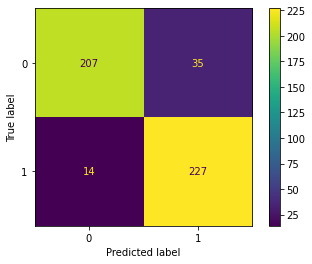

In [421]:
# plot confusion matric
plot_confusion_matrix(lr, X_test_features, y_test)  

In [422]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 207
False Positives: 35
False Negatives: 14
True Positives: 227


In [503]:
# Model evaluation
print('Accuracy:', round(((tp+tn)/(tp+tn+fp+fn)),4))
print('Sensitivity:', round(((tp)/(tp+fn)),4))
print('Specificity:', round(((tn)/(tn+fp)),4))
print('Precision:', round(((tp)/(tp+fp)),4))

Accuracy: 0.8986
Sensitivity: 0.9419
Specificity: 0.8554
Precision: 0.8664


### Results with Coefficient

Explore which words are the most important in determining whether a post is from the scubadiving subreddit or hiking sub reddit.

Obtaining the logistic regression beta coefficients:

In [429]:
# dataframe to display all features that use in selected model
count_df = pd.DataFrame(X_test_features.toarray(),columns=cvec.get_feature_names())
count_df.head()

aa  aa aaa  aa batteri  aaa  ab  abil  abl  abl carri  abl carri nuanc  \
0   0       0           0    0   0     0    0          0                0   
1   0       0           0    0   0     0    0          0                0   
2   0       0           0    0   0     0    0          0                0   
3   0       0           0    0   0     0    0          0                0   
4   0       0           0    0   0     0    0          0                0   

   abl find  aboard  abroad  absolut  ac  acadia  accept  access  accessori  \
0         0       0       0        0   0       0       0       0          0   
1         0       0       0        0   0       0       0       0          0   
2         0       0       0        0   0       0       0       0          0   
3         0       0       0        0   0       0       0       0          0   
4         0       0       0        0   0       0       0       0          0   

   accid  accident  accommod  accomplish  accord  account  accur  achiev  \
0      0         0         0           0       0        0      0       0   
1      0         0         0           0       0        0      0       0   
2      0         0         0           0       0        0      0       0   
3      0         0         0           0       0        0      0       0   
4      0         0         0           0       0        0      0       0   

   across  action  activ  activ end  activ end design  activ like  activ real  \
0       0       0      0          0                 0           0           0   
1       0       0      0          0                 0           0           0   
2       0       0      0          0                 0           0           0   
3       0       0      0          0                 0           0           0   
4       0       0      0          0                 0           0           0   

   activ real idea  activ sport  activ sport gener  activ teach  \
0                0            0                  0            0   
1                0            0                  0            0   
2                0            0                  0            0   
3                0            0                  0            0   
4                0            0                  0            0   

   activ teach cours  actual  ad  adapt  add  addict  addit  adept  \
0                  0       0   0      0    0       0      0      0   
1                  0       0   0      0    0       0      0      0   
2                  0       0   0      0    0       0      0      0   
3                  0       0   0      0    0       0      0      0   
4                  0       0   0      0    0       0      0      0   

   adept thru  adept thru camp  adjust  adopt  ador  advanc  advanc edit  \
0           0                0       0      0     0       0            0   
1           0                0       0      0     0       0            0   
2           0                0       0      0     0       0            0   
3           0                0       0      0     0       0            0   
4           0                0       0      0     0       0            0   

   advanc open  advanc open water  advanc padi  advantag  adventur  \
0            0                  0            0         0         0   
1            0                  0            0         0         0   
2            0                  0            0         0         0   
3            0                  0            0         0         0   
4            0                  0            0         0         0   

   adventur outdoor  adventur outdoor recreat  advertis  advic  advic get  \
0                 0                         0         0      0          0   
1                 0                         0         0      0          0   
2                 0                         0         0      0          0   
3                 0                         0         0      0          0   
4                 0               

In [431]:
# total 4000 featues
count_df.shape

(483, 4000)

Creating dataframe and calculating the log odds of each coefficient for interpretability.

In [551]:
# get coef score of each words
score = np.exp(lr.coef_[0])

In [552]:
# get word name of each words
word = cvec.get_feature_names()

In [555]:
# combine words and score  into dataframe
eval_df = pd.DataFrame( {'word': word, 'score' :score})
eval_df.head()

,word,score
0,aa,1.095394
1,aa aaa,1.000519
2,aa batteri,1.045035
3,aaa,1.000519
4,ab,0.946102


In [557]:
eval_df.sort_values(by='score',ascending=True).head(10)

,word,score
3485,trail,0.065556
2090,mountain,0.119310
3630,usa,0.153313
2328,park,0.185454
1397,forest,0.238785
2100,mt,0.241256
1258,fall,0.247732
717,colorado,0.255013
2798,scotland,0.256992
565,canyon,0.278123


In [558]:
eval_df.sort_values(by='score',ascending=False).head(10)

,word,score
2904,shark,3.117894
3593,underwat,3.066413
2817,sea,3.038990
3567,turtl,2.960519
1364,fish,2.822931
2210,octopu,2.734695
2003,manta,2.629312
1122,eel,2.562826
633,certif,2.478968
2014,mask,2.476469


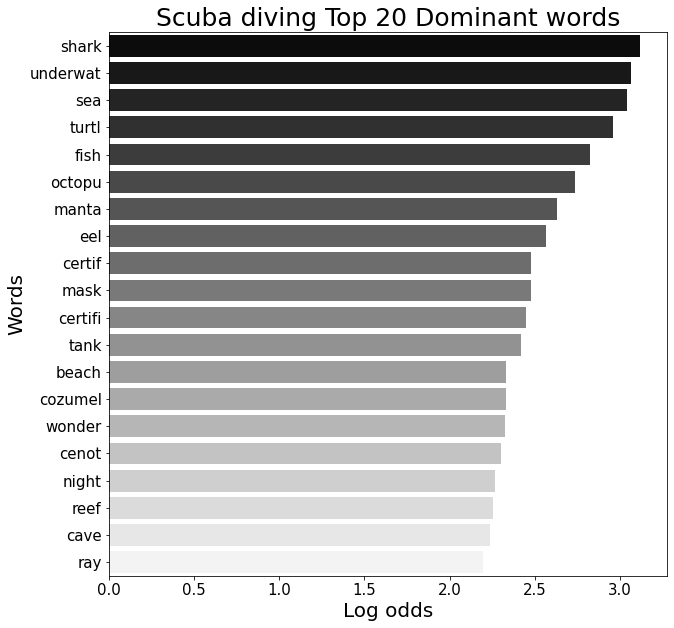

In [559]:
plt.figure(figsize=(10,10))
plt.title('Scuba diving Top 20 Dominant words',fontsize=25)
sns.barplot(data=eval_df.sort_values(by='score',ascending=False).head(20),x='score',y='word',orient='h', palette='gist_gray')
plt.xlabel('Log odds',fontsize=20)
plt.ylabel('Words',fontsize=20)
plt.tick_params(labelsize=15)

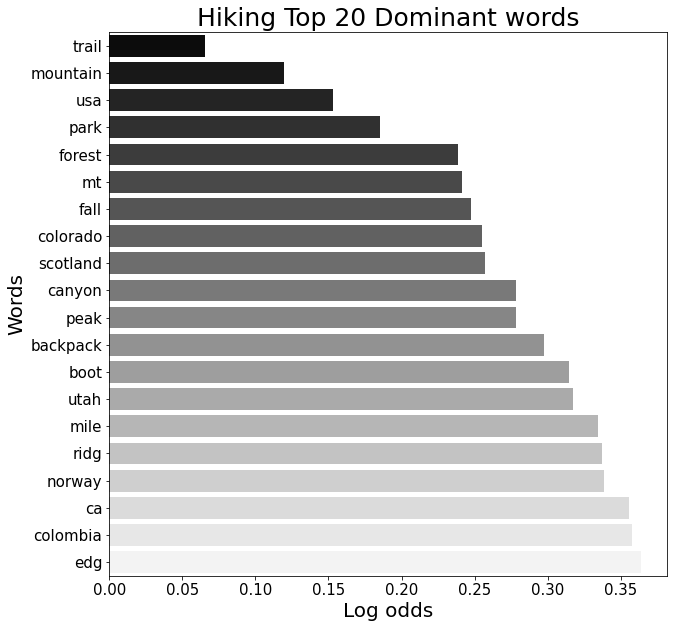

In [567]:
plt.figure(figsize=(10,10))
plt.title('Hiking Top 20 Dominant words',fontsize=25)
sns.barplot(data=eval_df.sort_values(by='score',ascending=True).head(20),x='score',y='word',orient='h',palette='gist_gray')
plt.xlabel('Log odds',fontsize=20)
plt.ylabel('Words',fontsize=20)
plt.tick_params(labelsize=15)

In [561]:
false_df = pd.DataFrame({'Predition':predictions, 'Actual':y_test, 'text': X_test})
false_df['false'] = false_df['Predition'] - false_df['Actual']

In [540]:
# Display only false prediction
false_df.loc[(false_df['false'] == 1)  | (false_df['false'] == -1)].head()

,Predition,Actual,text,false
912,0,1,north monasteri calm morn monterey ca,-1
1866,1,0,taho rim traili hope accomplish trt thru summe...,1
1581,1,0,vibram sole accept patch super hard boot spend...,1
1840,1,0,near vega get cold west ticket vega cheap enou...,1
294,0,1,noaa expand flower garden bank nation marin sa...,-1


Fuction for check dominant words

In [569]:
def check_word(i):    
    word_list = []
    score_list = []
    for word in set(false_df['text'][i].split()):
        if word in cvec.get_feature_names():
            word_list.append(word)
            score = eval_df.loc[(eval_df['word'] == word)]['score'].array[0]
            score_list.append(score)
    print(f"Original text: {reddit['text'][i]}")
    print(' ')
    print(f"Stem and Clean text: {false_df['text'][i]}")
    print(' ')
    if false_df['false'][i] == 1:
        print('Predict: Scuba')
        print('Actual: Hiking')
    else:
        print('Predict: Hiking')
        print('Actual: Scuba')
    false_word_df = pd.DataFrame(list(zip(word_list, score_list)), columns =['word', 'score']) 
    display(false_word_df.sort_values(by='score').head(5))
    display(false_word_df.sort_values(by='score', ascending = False).head(5))

In [570]:
check_word(912)

Original text: north monastery on a calm morning, monterey ca
 
Stem and Clean text: north monasteri calm morn monterey ca
 
Predict: Hiking
Actual: Scuba


,word,score
0,ca,0.355459
1,north,0.478423
3,morn,0.929911
2,calm,1.035255
4,monterey,1.478502


,word,score
4,monterey,1.478502
2,calm,1.035255
3,morn,0.929911
1,north,0.478423
0,ca,0.355459


This post tend to post a picture 

In [571]:
check_word(1457)

Original text: i need a new hobby. is hiking something you can do everyday after work?with the pandemic i need  a new hobby. i'm  not sure how much time i need after work or if i'll  still have enough energy. just wondering.
 
Stem and Clean text: hobbi someth everyday work pandem hobbi sure much work still enough energi wonder
 
Predict: Scuba
Actual: Hiking


,word,score
7,enough,0.761905
1,hobbi,0.833327
2,someth,0.897862
3,still,0.942617
6,much,1.025014


,word,score
8,wonder,2.324514
5,work,1.558144
4,sure,1.352472
0,pandem,1.041188
6,much,1.025014


When remove the keyword 'hiking' the post will become a generic question about suggestion for new hobby which is generic

### Conclsion

Results from final model shows that posts in scuba diving and hiking subreddit are fairly different, and can classify with an accuracy of 89.86%

The differences of the words are mainly due to creatures under the sea in scuba diving activity and how to describe location both activities

### Recommendations

For further model prediction improvement
<ul>
    <li>Optimize stop words</li>
    <li>Increase number of posts for training data to have more words </li>
    <li>Include more text such as  comments in each posts</li>
    <li>Use an image as a features</li>
</ul>